# Imports

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
from matplotlib import pylab as plt
import sklearn
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/arrests.csv')

In [3]:
np.random.seed(1)

# EDA

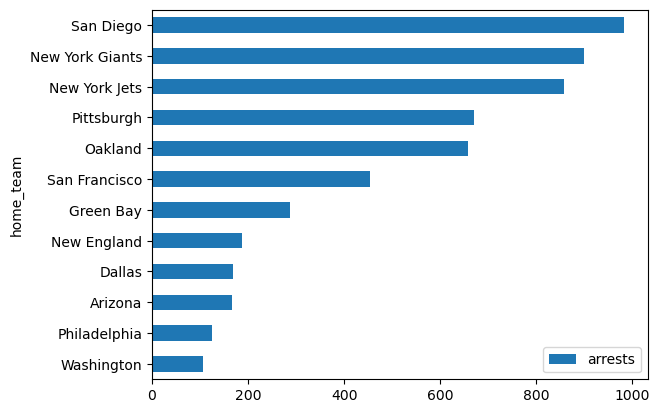

In [4]:
df[["home_team", 'arrests']].groupby("home_team").sum().sort_values("arrests").tail(12).plot(kind='barh')
plt.show()

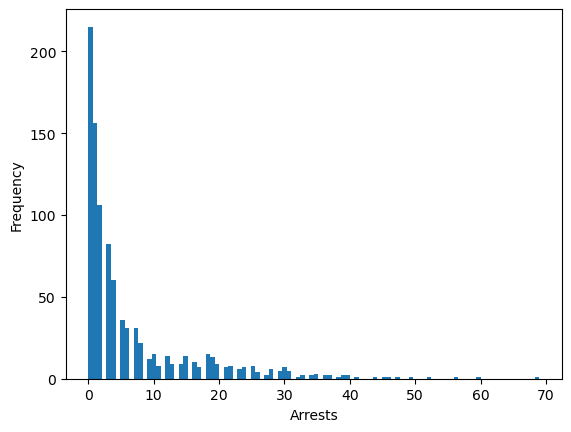

In [5]:
plt.hist(df['arrests'], bins=100)
plt.xlabel("Arrests")
plt.ylabel("Frequency")
plt.show()

In [6]:
list(df.columns)

['season',
 'week_num',
 'day_of_week',
 'gametime_local',
 'home_team',
 'away_team',
 'home_score',
 'away_score',
 'OT_flag',
 'arrests',
 'division_game']

In [7]:
df.shape

(1006, 11)

In [8]:
df.dtypes

season              int64
week_num            int64
day_of_week        object
gametime_local     object
home_team          object
away_team          object
home_score          int64
away_score          int64
OT_flag            object
arrests           float64
division_game      object
dtype: object

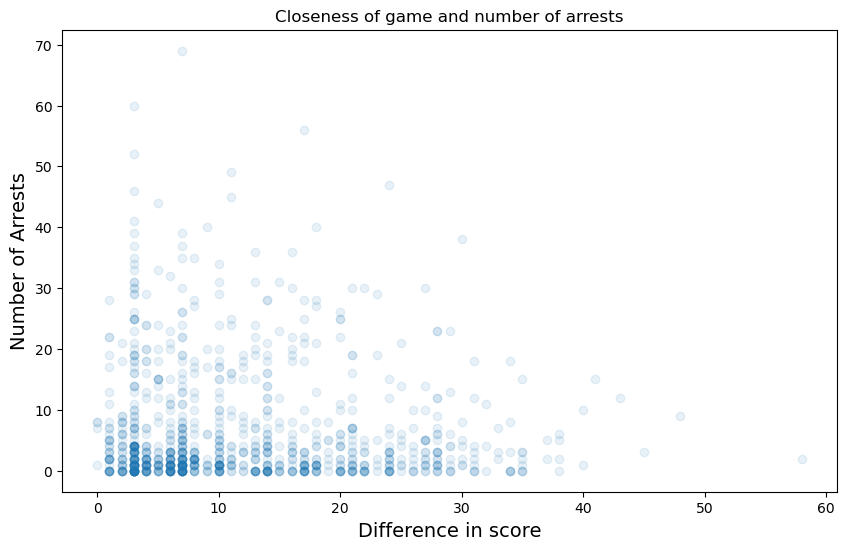

In [9]:
plt.figure(figsize=(10,6))
plt.scatter(np.abs(df.home_score - df.away_score), df.arrests, alpha=0.1)
plt.xlabel("Difference in score", fontsize=14)
plt.ylabel("Number of Arrests", fontsize=14)
plt.title("Closeness of game and number of arrests")
plt.show()

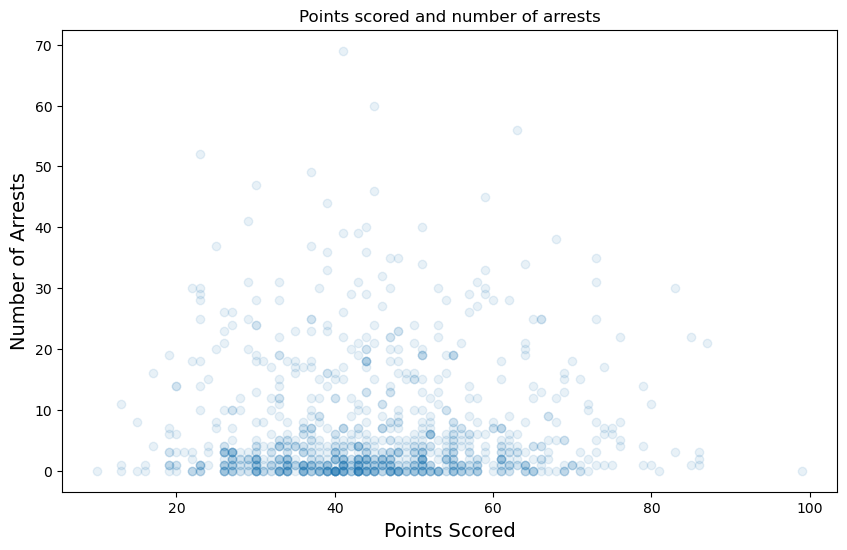

In [10]:
plt.figure(figsize=(10,6))
plt.scatter(np.abs(df.home_score + df.away_score), df.arrests, alpha=0.1)
plt.xlabel("Points Scored", fontsize=14)
plt.ylabel("Number of Arrests", fontsize=14)
plt.title("Points scored and number of arrests")
plt.show()

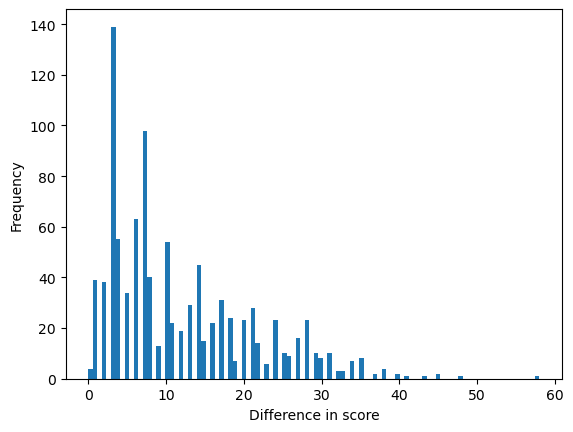

In [11]:
plt.hist(np.abs(df.home_score - df.away_score), bins=100)
plt.xlabel("Difference in score")
plt.ylabel("Frequency")
plt.show()

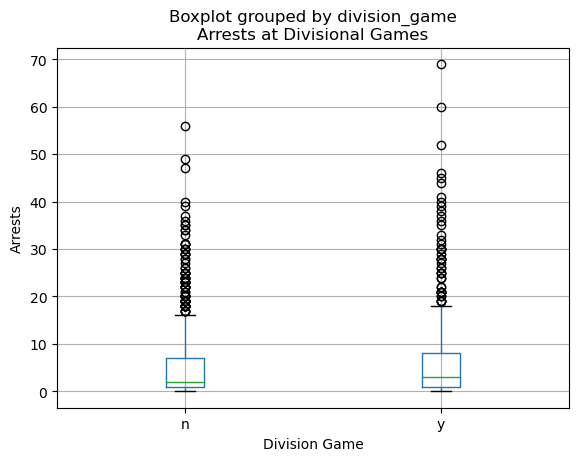

In [12]:
df[['division_game','arrests']].boxplot(by='division_game')
plt.ylabel('Arrests')
plt.xlabel('Division Game')
plt.title("Arrests at Divisional Games")
plt.show()

# Preprocessing

In [13]:
from datetime import datetime
a = pd.to_datetime(df.gametime_local, format='%H:%M:%S %p')
b = a.dt.hour
def gametime(x):
    if x < 4 or x == 12:
        return "afternoon"
    if x < 7:
        return "evening"
    return "night"
b.apply(gametime)
df.gametime_local = b.apply(gametime)

In [14]:
df.OT_flag = df.OT_flag.fillna("n").replace("OT", "y")

In [15]:
df['points_scored'] = df.home_score + df.away_score
df['score_diff_abs'] = np.abs(df.home_score - df.away_score)
df['score_diff'] = df.home_score - df.away_score
df['home_win'] = (df.score_diff / df.score_diff_abs).replace(-1, "n").replace(1, "y")

In [16]:
df.head()

,season,week_num,day_of_week,gametime_local,home_team,away_team,home_score,away_score,OT_flag,arrests,division_game,points_scored,score_diff_abs,score_diff,home_win
0,2011,1,Sunday,afternoon,Arizona,Carolina,28,21,n,5.0,n,49,7,7,y
1,2011,4,Sunday,afternoon,Arizona,New York Giants,27,31,n,6.0,n,58,4,-4,n
2,2011,7,Sunday,afternoon,Arizona,Pittsburgh,20,32,n,9.0,n,52,12,-12,n
3,2011,9,Sunday,afternoon,Arizona,St. Louis,19,13,y,6.0,y,32,6,6,y
4,2011,13,Sunday,afternoon,Arizona,Dallas,19,13,y,3.0,n,32,6,6,y


In [17]:
y = df.arrests.fillna(0)
X = df.drop('arrests', axis=1)

In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

std_ftrs = ['home_score', 'away_score', 'points_scored', 'score_diff', 'score_diff_abs']
cat_ftrs = ['day_of_week', 'gametime_local', 'home_team', 'away_team', 'OT_flag', 'division_game', 'home_win']
ordinal_ftrs = ['season', 'week_num']
ordinal_cats = [[2011, 2012, 2013, 2014, 2015],[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]]

random_state = 42

# one-hot encoder
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])

# Ordinal encoder
ordinal_transformer = Pipeline(steps=[('ordinal', OrdinalEncoder(categories = ordinal_cats))])

# standard scaler
std_scaler_transformer = Pipeline(steps=[('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', categorical_transformer, cat_ftrs),
        ('ordinal', ordinal_transformer, ordinal_ftrs),
        ('std', std_scaler_transformer, std_ftrs)])

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_other, y_train, y_other = train_test_split(X, y, test_size=.4)
X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, test_size=.5)

final_scaler = StandardScaler()

X_train = preprocessor.fit_transform(X_train)
X_train = final_scaler.fit_transform(X_train)
X_val = final_scaler.transform(preprocessor.transform(X_val))
X_test = final_scaler.transform(preprocessor.transform(X_test))

# Modeling

In [20]:
from sklearn.metrics import mean_squared_error

In [21]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train, y_train)
print("Linear Regression Validation MSE: ", mean_squared_error(y_val, linreg.predict(X_val)))

Linear Regression Validation MSE:  3.015985540775713e+24


In [22]:
from sklearn.linear_model import Lasso

alphas = np.logspace(-2, 2, num=15)

min_alpha = alphas[0]
min_mse = 10000

for alpha in alphas:
    lassoreg = Lasso(alpha=alpha)
    lassoreg.fit(X_train, y_train)
    curr_mse = mean_squared_error(y_val, lassoreg.predict(X_val))
    if curr_mse < min_mse:
        min_mse = curr_mse
        min_alpha = alpha

print("L1 Regression Validation MSE: ", min_mse, "Alpha = ", min_alpha)

L1 Regression Validation MSE:  38.16200221846368 Alpha =  0.01


In [23]:
from sklearn.linear_model import Ridge

alphas = np.logspace(-2, 2, num=15)

min_alpha = alphas[0]
min_mse = 10000

for alpha in alphas:
    ridgereg = Ridge(alpha=alpha)
    ridgereg.fit(X_train, y_train)
    curr_mse = mean_squared_error(y_val, ridgereg.predict(X_val))
    if curr_mse < min_mse:
        min_mse = curr_mse
        min_alpha = alpha

print("L2 Regression Validation MSE: ", min_mse, "Alpha = ", min_alpha)

L2 Regression Validation MSE:  38.22003781950499 Alpha =  0.01


In [24]:
from sklearn.svm import SVR

gammas = np.logspace(-3, 5, num=15)
Cs = np.logspace(-2, 2, num=15)

min_gamma = gammas[0]
min_C = Cs[0]
min_mse = 10000

for C in Cs:
    for gamma in gammas:
        svreg = SVR(gamma=gamma, C=C)
        svreg.fit(X_train, y_train)
        curr_mse = mean_squared_error(y_val, svreg.predict(X_val))
        if curr_mse < min_mse:
            min_mse = curr_mse
            min_C = C
            min_gamma = gamma

print("Support Vector Regression Validation MSE: ", min_mse)

Support Vector Regression Validation MSE:  41.68891360287425


# Testing

In [25]:
## Best model was L1 regression with a regularization coefficient of 0.019

l1reg = Lasso(alpha=0.019)
l1reg.fit(X_train, y_train)
print("L1 Regression Test MSE: ", mean_squared_error(y_test, linreg.predict(X_test)))

L1 Regression Test MSE:  28.322814244626677


# Interpretation

In [26]:
highest_coeff = np.argsort(np.abs(l1reg.coef_))[-15:]
column_names = preprocessor.get_feature_names_out()

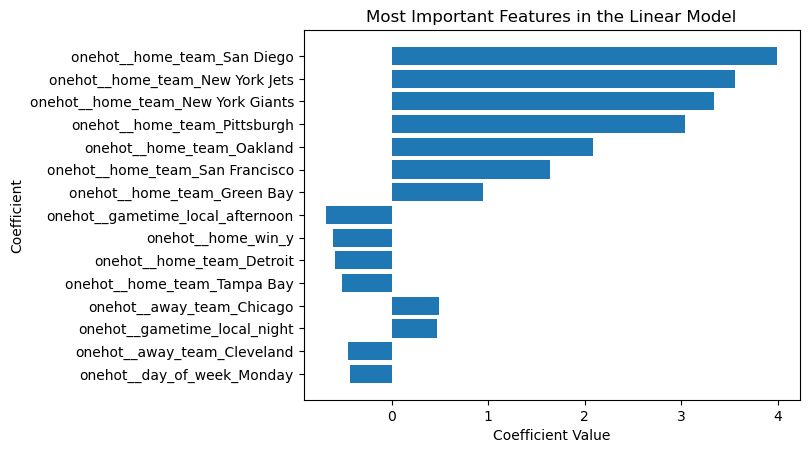

In [27]:
plt.barh(column_names[highest_coeff], l1reg.coef_[highest_coeff])
plt.title("Most Important Features in the Linear Model")
plt.xlabel("Coefficient Value")
plt.ylabel("Coefficient")
plt.show()